<h3> Generalised Linear Models </h3>

 A generalized linear model (GLM) is much like the
linear regressions of previous chapters.
It is a model that replaces a parameter of a likelihood function with a linear model.
But GLMs need not use Gaussian likelihoods.
Any likelihood function can be used, and linear models can be attached to any or all of the parameters that describe its shape.
The principle of maximum entropy helps us choose likelihood functions,by providing a way to use stated assumptions about constraints on the outcome variable to choose the likelihood function that is the most conservative distribution compatible with
the known constraints.


In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.special import expit

In [4]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [5]:
data = pd.read_csv('Data/challenger3.csv', parse_dates=[0])

# avoiding column names with spaces
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

In [6]:
data.drop(labels=[3, 24], inplace=True)

# convert the Damage column to integer
data['Damage'] = data['Damage'].astype(float)

In [7]:
data = pd.read_csv('Data/challenger3.csv', parse_dates=[0])

# avoiding column names with spaces
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# dropping row 3, in which Damage Incident is NaN,
# and row 24, which is the record for the Challenger
data.drop(labels=[3, 24], inplace=True)

# convert the Damage column to integer
data['Damage'] = data['Damage'].astype(int)

data

Date  Temperature  Damage
0  1981-04-12           66       0
1  1981-11-12           70       1
2  1982-03-22           69       0
4  1982-01-11           68       0
5  1983-04-04           67       0
6  1983-06-18           72       0
7  1983-08-30           73       0
8  1983-11-28           70       0
9  1984-02-03           57       1
10 1984-04-06           63       1
11 1984-08-30           70       1
12 1984-10-05           78       0
13 1984-11-08           67       0
14 1985-01-24           53       1
15 1985-04-12           67       0
16 1985-04-29           75       0
17 1985-06-17           70       0
18 1985-07-29           81       0
19 1985-08-27           76       0
20 1985-10-03           79       0
21 1985-10-30           75       1
22 1985-11-26           76       0
23 1986-01-12           58       1

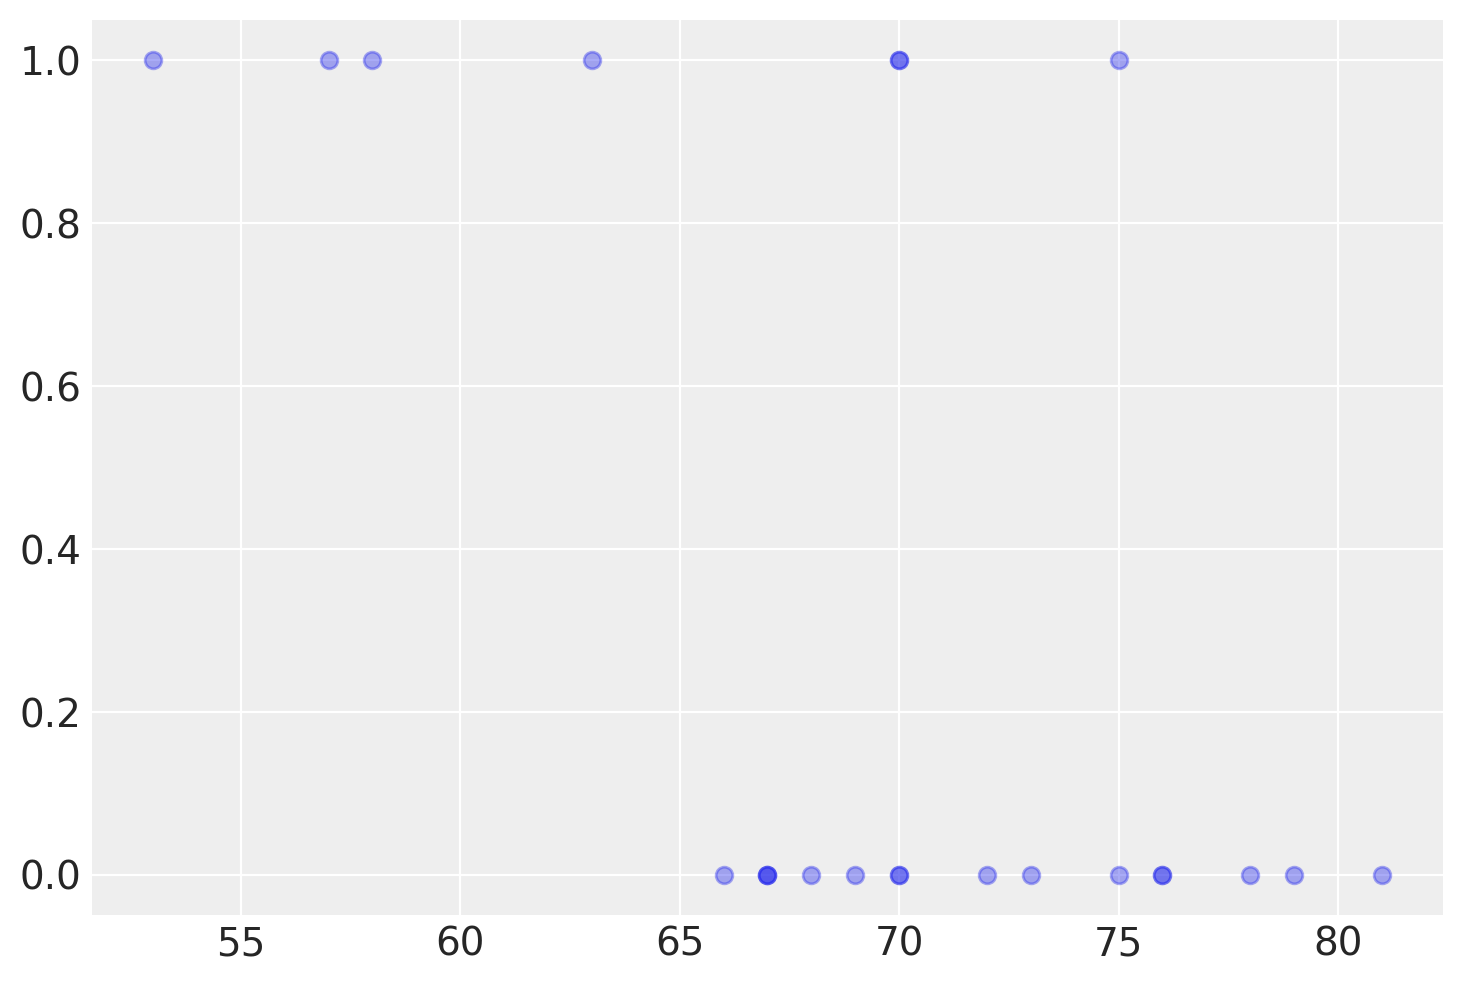

In [36]:
 plt.plot(data['Temperature'], data['Damage'], 'o', 
             label='data', color='C0', alpha=0.4)

<h3> yi ∼ Binomial(n, pi)</h3>

<h3> f(pi) = α + β(xi − ¯x)</h3>

why not use 
<h3> p= α + β(xi − ¯x)</h3>
A link function’s job is to map the linear space of a modellike α + β(xi − ¯x) onto the non-linear space of a parameter like θ.
So f is chosen with that goal in mind.
Most of the time, for most GLMs, you can use one of two exceedingly common links, a logit link or a log link.

The logit link maps a parameter that is defined as a probability mass, and therefore constrained to lie between zero and one, onto a linear model that can take on any real value.

This link is extremely common when working with binomial GLMs. In the context of a model definition, it looks like this:

<h3>yi ∼ Binomial(n, pi)<h3>
    <h3>logit(pi) = α + βxi</h3>
And the logit function itself is defined as the log-odds:
    
<h3> logit(pi) = log pi/(1 − p)</h3>



<h3>
pi =
exp(α + βxi)/(1 + exp(α + βxi)
    </h3>


In [50]:
coords = {"observation": data.index.values}
with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("Temperature", data["Temperature"], dims="observation")
    # priors
    β0 = pm.Normal("B0", mu=15,tau=0.001)
    β1 = pm.Normal("B1", mu=-0.2, tau=0.001)
    # linear model
    μ = β0 + β1 * x
    p = pm.Deterministic("p", pm.math.invlogit(μ), dims="observation")
    # likelihood
    pm.Binomial("y", n=1, p=p, observed=data["Damage"], dims="observation")


In [ ]:

#return_inferencedatabool, default=FalseWhether to return the trace as an arviz.InferenceData (True) object or a MultiTrace (False) Defaults to False, but we’ll switch to True in an upcoming release.
with binomial_regression_model:
   
    trace = pm.sample(120000, tune=100000, return_inferencedata=True)

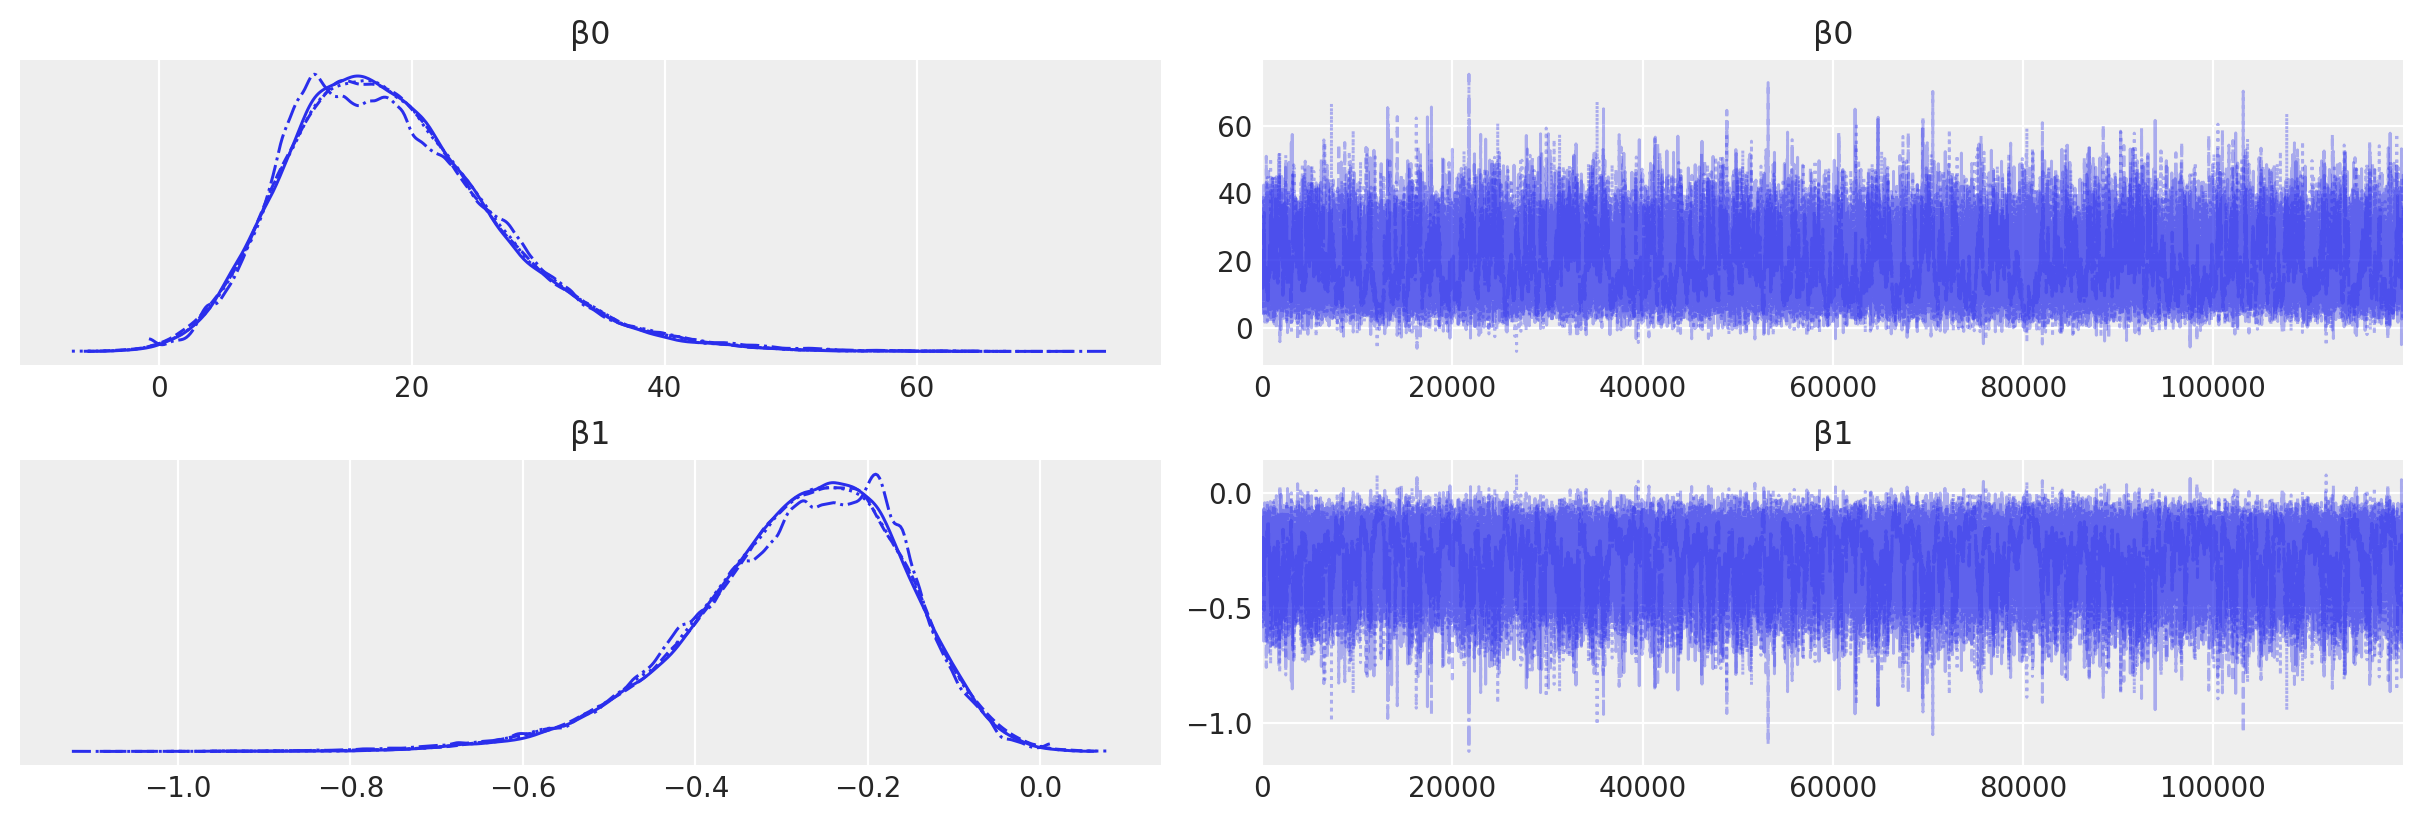

In [41]:
az.plot_trace(trace, var_names=["B0", "B1"]);

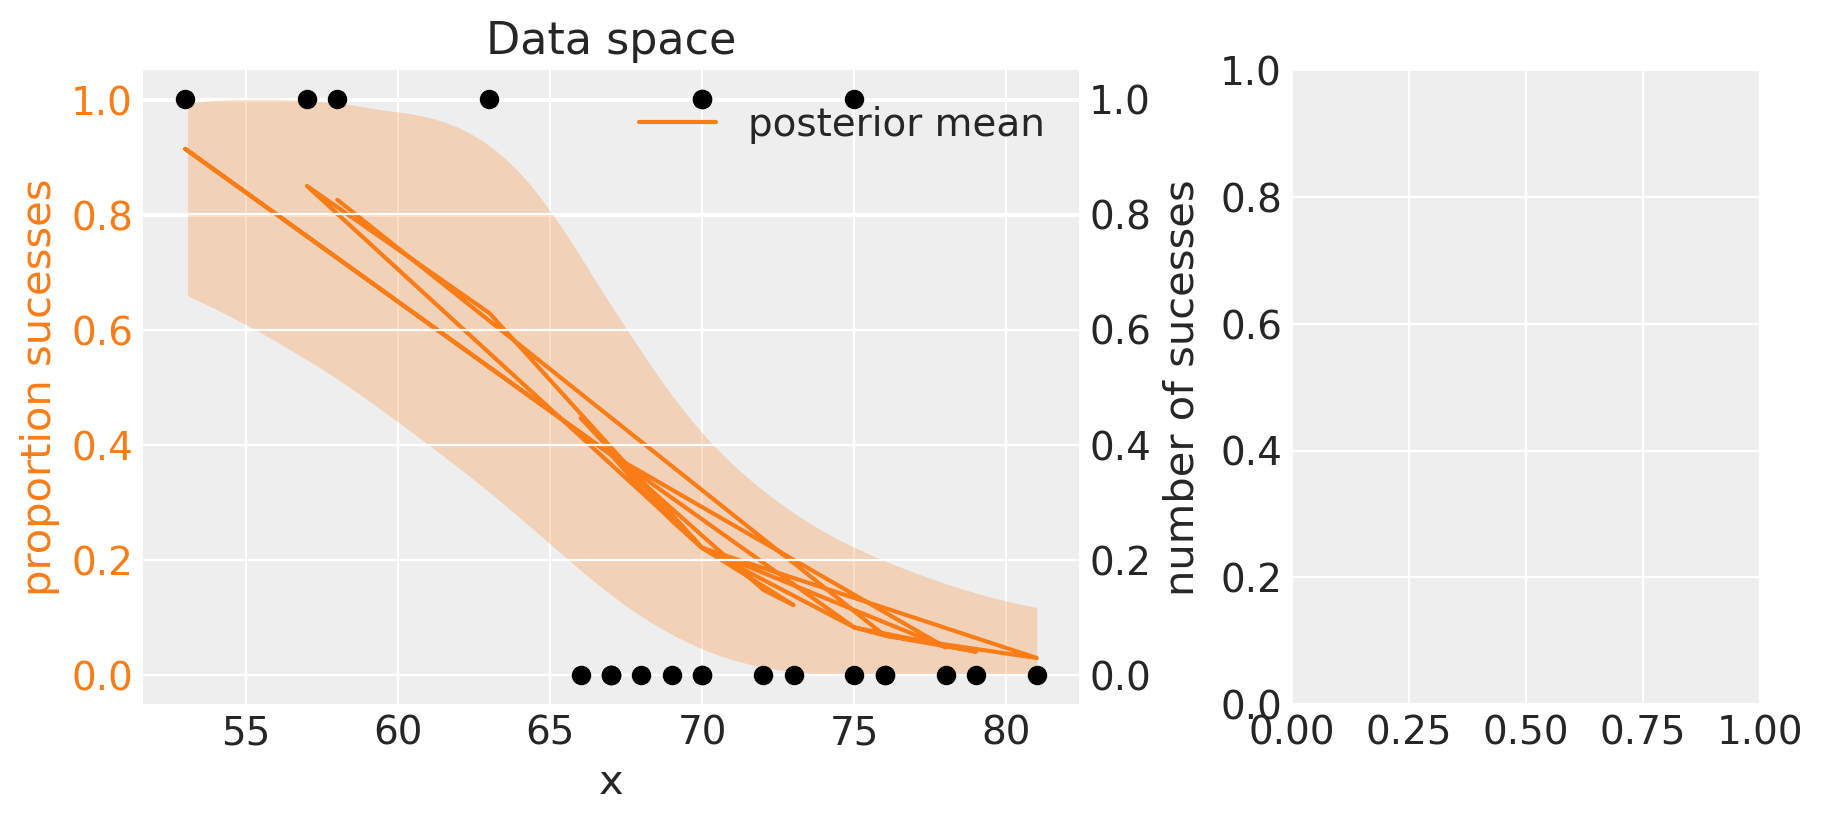

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["Temperature"],
    trace.posterior["p"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = trace.posterior.stack(sample=("chain", "draw"))["p"].mean("sample")
ax[0].plot( data["Temperature"], post_mean, label="posterior mean", color="C1")

ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of sucesses")
freq.scatter( data["Temperature"], data["Damage"], color="k", label="data")
# get y-axes to line up
#y_buffer = 1
#n=23
#freq.set(ylim=[-y_buffer, n + y_buffer])
#ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
#freq.grid(None)
# set both y-axis to have 5 ticks
#ax[0].set(yticks=np.linspace(0, 20, 5) / n)
#freq.set(yticks=np.linspace(0, 20, 5))

In [8]:
alpha_samples=trace["B0"]
beta_samples=trace["B1"]
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))


#figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

NameError: name 'trace' is not defined

<h1> Gender and Admission </h1>

In [9]:
d_ad = pd.read_csv("Data/UCBadmit.csv", sep=";")
d_ad


dept applicant.gender  admit  reject  applications
1     A             male    512     313           825
2     A           female     89      19           108
3     B             male    353     207           560
4     B           female     17       8            25
5     C             male    120     205           325
6     C           female    202     391           593
7     D             male    138     279           417
8     D           female    131     244           375
9     E             male     53     138           191
10    E           female     94     299           393
11    F             male     22     351           373
12    F           female     24     317           341

Our job is to evaluate whether these data contain evidence of gender bias in admissions.
We will model the admission decisions, focusing on applicant gender as a predictor variable.
So we want to fit a binomial regression that models admit as a function of each applicant’s
gender. This will estimate the association between gender and probability of admission. This
is what the model looks like, in mathematical form:

Ai ∼ Binomial(Ni, pi)

logit(pi) = αgid[i]

αj ∼ Normal(0, 1.5)


In [10]:
gid = (d_ad["applicant.gender"] == "female").astype(int).values
gid

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [11]:


with pm.Model() as m11_7:
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_11_7 = pm.sample()
az.summary(trace_11_7, var_names=["a"], round_to=2)

C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_12472/267447512.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_7 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.22  0.04   -0.29    -0.15        0.0      0.0   3072.44   2523.01   
a[1] -0.83  0.05   -0.93    -0.74        0.0      0.0   3567.90   3108.15   

      r_hat  
a[0]    1.0  
a[1]    1.0

In [12]:
az.summary(trace_11_7, var_names=["a"], round_to=2)

C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.22  0.04   -0.29    -0.15        0.0      0.0   3072.44   2523.01   
a[1] -0.83  0.05   -0.93    -0.74        0.0      0.0   3567.90   3108.15   

      r_hat  
a[0]    1.0  
a[1]    1.0

The posterior for male applicants, a[1], is higher than that of female applicants. How much
higher? We need to compute the contrast. Let’s calculate the contrast on the logit scale
 as well as the contrast on the outcome scale :

In [57]:
diff_a = trace_11_7["a"][:, 0] - trace_11_7["a"][:, 1]
diff_p = expit(trace_11_7["a"][:, 0]) - expit(trace_11_7["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

mean    sd  hdi_3%  hdi_97%
diff_a  0.61  0.07    0.48     0.72
diff_p  0.14  0.01    0.11     0.17

 d_ad.applications.values[None, :]The log-odds difference is certainly positive, corresponding to a higher probability of admission for male applicants. On the probability scale itself, the difference is somewhere between
12% and 16%.

In [13]:
 d_ad.applications.values
    

array([825, 108, 560,  25, 325, 593, 417, 375, 191, 393, 373, 341],
      dtype=int64)

In [75]:
trace_11_7.varnames

['a', 'p']

In [15]:
with m11_7:
    ppc = pm.sample_posterior_predictive(trace_11_7, random_seed=42, var_names=["p"])[ "p"]
pp_admit = ppc / d_ad.applications.values[None, :]

C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


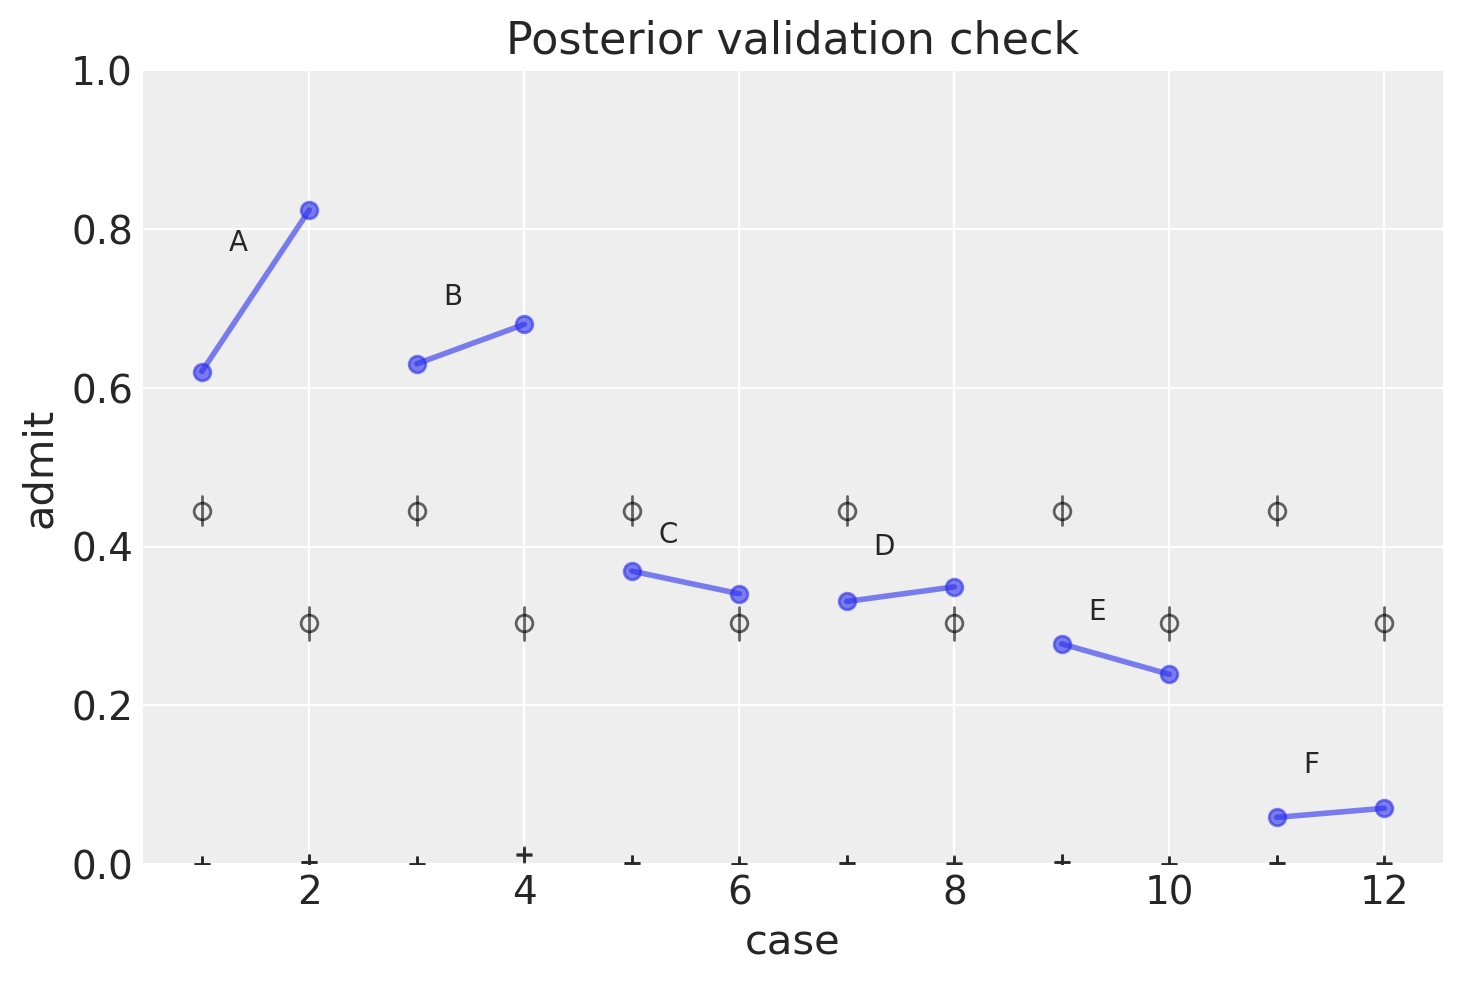

In [16]:
for i in range(6):
    x = 1 + 2 * i

    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x + 1] / d_ad.applications[x + 1]

    plt.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1 + y2) / 2 + 0.05, d_ad.dept[x])

plt.plot(range(1, 13), trace_11_7["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(trace_11_7["p"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(0, 1);

Those are pretty terrible predictions. There are only two
departments in which females had a lower rate of admission than males (C and E), and yet
the model says that females should expect to have a 14% lower chance of admission.
Sometimes a fit this bad is the result of a coding mistake. In this case, it is not. The
model did correctly answer the question we asked of it: What are the average probabilities
of admission for females and males, across all departments? The problem in this case is that
males and females do not apply to the same departments, and departments vary in their rates
of admission. This makes the answer misleading. You can see the steady decline in admission
probability for both males and females from department A to department F. Females in these
data tended not to apply to departments like A and B, which had high overall admission rates.
Instead they applied in large numbers to departments like F, which admitted less than 10%
of applicants.

So while it is true overall that females had a lower probability of admission in these data,
it is clearly not true within most departments. And note that just inspecting the posterior
distribution alone would never have revealed that fact to us. We had to appeal to something
outside the fit model. In this case, it was a simple posterior validation check.


Instead of asking “What are the average probabilities of admission for females and males
across all departments?” we want to ask “What is the average difference in probability of admission between females and males within departments?” In order to ask the second question, we
estimate unique female and male admission rates in each department. Here’s a model that
asks this new question:

Ai ∼ Binomial(Ni
, pi)

logit(pi) = αgid[i] + δdept[i]

αj ∼ Normal(0, 1.5)

δk ∼ Normal(0, 1.5)



In [17]:
dept_id = pd.Categorical(d_ad["dept"]).codes
dept_id

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], dtype=int8)

In [19]:
dept_id = pd.Categorical(d_ad["dept"]).codes

with pm.Model() as m11_8:
    a = pm.Normal("a", 0, 1.5, shape=2)
    delta = pm.Normal("delta", 0, 1.5, shape=6)

    p = pm.math.invlogit(a[gid] + delta[dept_id])

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_11_8 = pm.sample(2000, random_seed=42)
az.summary(trace_11_8, round_to=2)

C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_12472/3079355750.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_8 = pm.sample(2000, random_seed=42)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
The number of effective samples is smaller than 10% for some parameters.
C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]     -0.50  0.55   -1.58     0.49       0.02     0.01    742.49    963.89   
a[1]     -0.40  0.56   -1.48     0.60       0.02     0.01    752.59    922.84   
delta[0]  1.08  0.56    0.10     2.17       0.02     0.01    753.63    957.61   
delta[1]  1.03  0.56    0.03     2.10       0.02     0.01    750.73   1003.22   
delta[2] -0.18  0.56   -1.22     0.85       0.02     0.01    752.71    974.01   
delta[3] -0.21  0.56   -1.28     0.80       0.02     0.01    747.52    964.88   
delta[4] -0.66  0.56   -1.72     0.37       0.02     0.02    756.19    969.22   
delta[5] -2.21  0.57   -3.19    -1.07       0.02     0.01    783.02    981.23   

          r_hat  
a[0]        1.0  
a[1]        1.0  
delta[0]    1.0  
delta[1]    1.0  
delta[2]    1.0  
delta[3]    1.0  
delta[4]    1.0  
delta[5]    1.0

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], dtype=int8)

The intercept for male applicants, a[1], is now a little smaller on average than the one for
female applicants. Let’s calculate the contrasts against, both on relative and absolute
 scales:

In [20]:
diff_a = trace_11_8["a"][:, 0] - trace_11_8["a"][:, 1]
diff_p = expit(trace_11_8["a"][:, 0]) - expit(trace_11_8["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

mean    sd  hdi_3%  hdi_97%
diff_a -0.10  0.08   -0.25     0.05
diff_p -0.02  0.02   -0.06     0.01

In [86]:
pg = pd.DataFrame(index=["male", "female"], columns=d_ad.dept.unique())
for dep in pg.columns:
    pg[dep] = (
        d_ad.loc[d_ad.dept == dep, "applications"]
        / d_ad.loc[d_ad.dept == dep, "applications"].sum()
    ).values
pg.round(2)

A     B     C     D     E     F
male    0.88  0.96  0.35  0.53  0.33  0.52
female  0.12  0.04  0.65  0.47  0.67  0.48

Poisson Regression



Binomial GLMs are appropriate when the outcome is a count from zero to some known
upper bound. If you can analogize the data to the globe tossing model, then you should
use a binomial GLM. But often the upper bound isn’t know. Instead the counts never get
close to any upper limit. For example, if we go fishing and return with 17 fish, what was the
theoretical maximum? Whatever it is, it isn’t in our data. How do we model the fish counts?




yi ∼ Poisson(λ)
The parameter λ is the expected value of the outcome y. It is also the expected variance of
the counts y.
We also need a link function. The conventional link function for a Poisson model is the
log link,. So to embed a linear model, we
use:
yi ∼ Poisson(λi)
log(λi) = α + β(xi − ¯x)


Example

The island societies of Oceania provide a natural experiment in technological evolution. Different historical island populations possessed
tool kits of different size. These kits include fish hooks, axes, boats, hand plows, and many
other types of tools. A number of theories predict that larger populations will both develop
and sustain more complex tool kits. So the natural variation in population size induced by
natural variation in island size in Oceania provides a natural experiment to test these ideas.
It’s also suggested that contact rates among populations effectively increase population size,
as it’s relevant to technological evolution. So variation in contact rates among Oceanic societies is also relevant

In [21]:
dk = pd.read_csv("Data/Kline2.csv", sep=",")
dk

culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   
5   Trobriand        8000    high           19      4.0  -8.7  150.9 -29.1   
6       Chuuk        9200    high           40      3.8   7.4  151.6 -28.4   
7       Manus       13000     low           28      6.6  -2.1  146.9 -33.1   
8       Tonga       17500    high           55      5.4 -21.2 -175.2   4.8   
9      Hawaii      275000     low           71      6.6  19.9 -155.6  24.4   

      logpop  
0   7.003065  
1   7.313220  
2   8.188689  
3   8.474494  
4   8.909235  
5   8.987197  
6   9.126959  
7   9.472705  
8   9.769956  
9  12.524526

In [22]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

P = standardize(np.log(dk.population)).values
c_id = (dk.contact == "high").astype(int).values

Ti ∼ Poisson(λi)

log λi = α

α ∼ Normal(0, 10)

if a is normal then  lambda is lognormal.



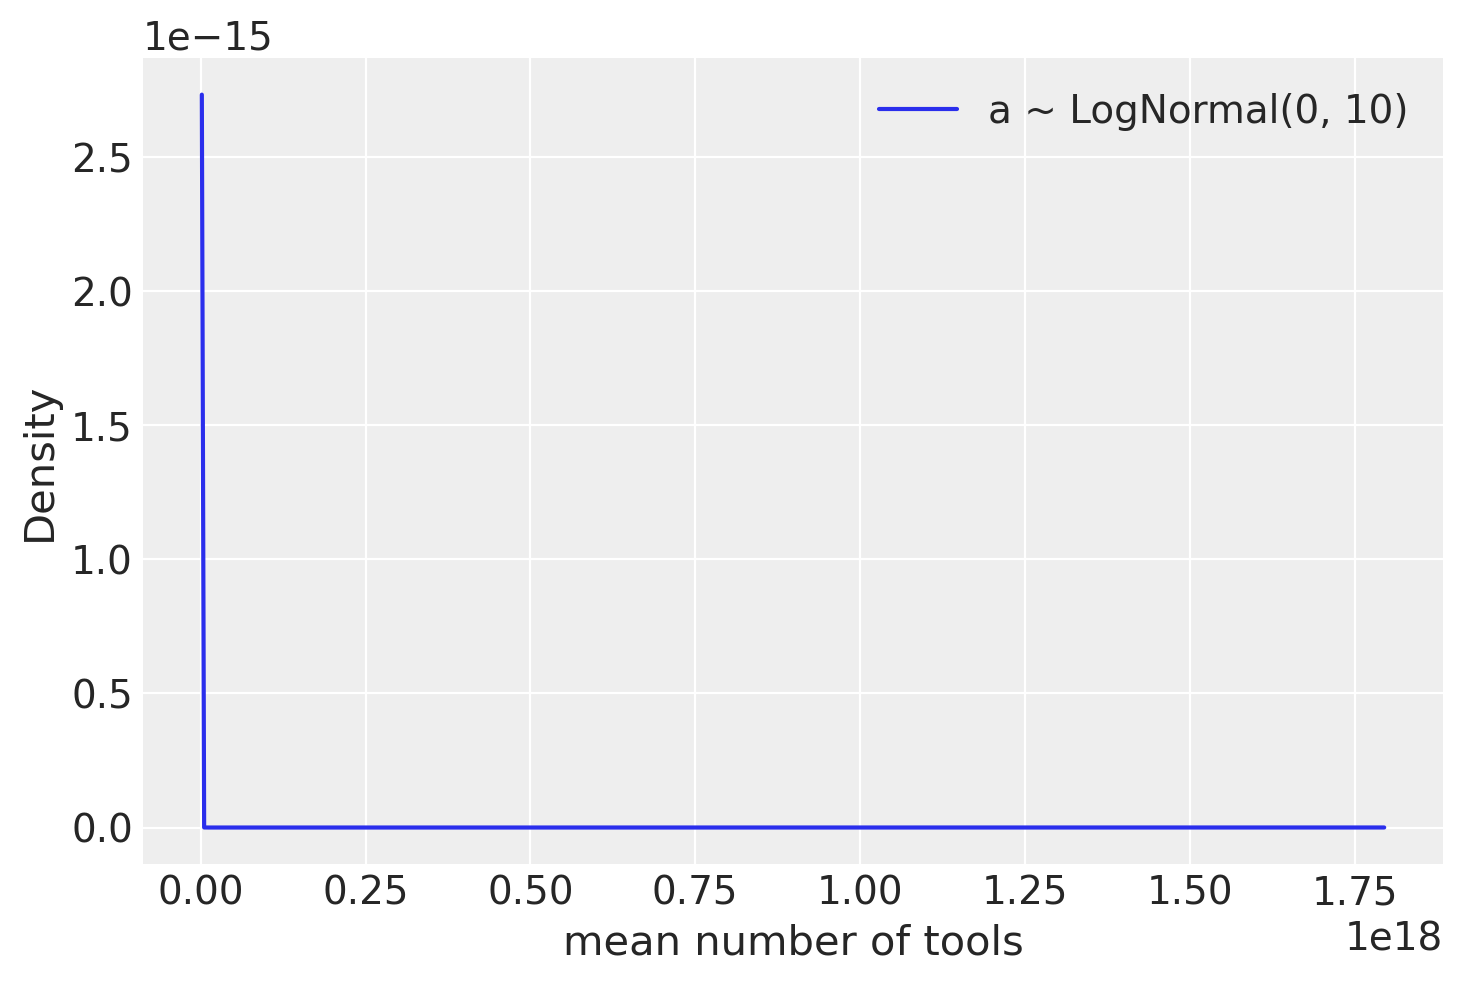

In [23]:
ax = az.plot_kde(
    pm.Lognormal.dist(0.0, 10.0).random(size=20_000),
    label="a ~ LogNormal(0, 10)"
   
)
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

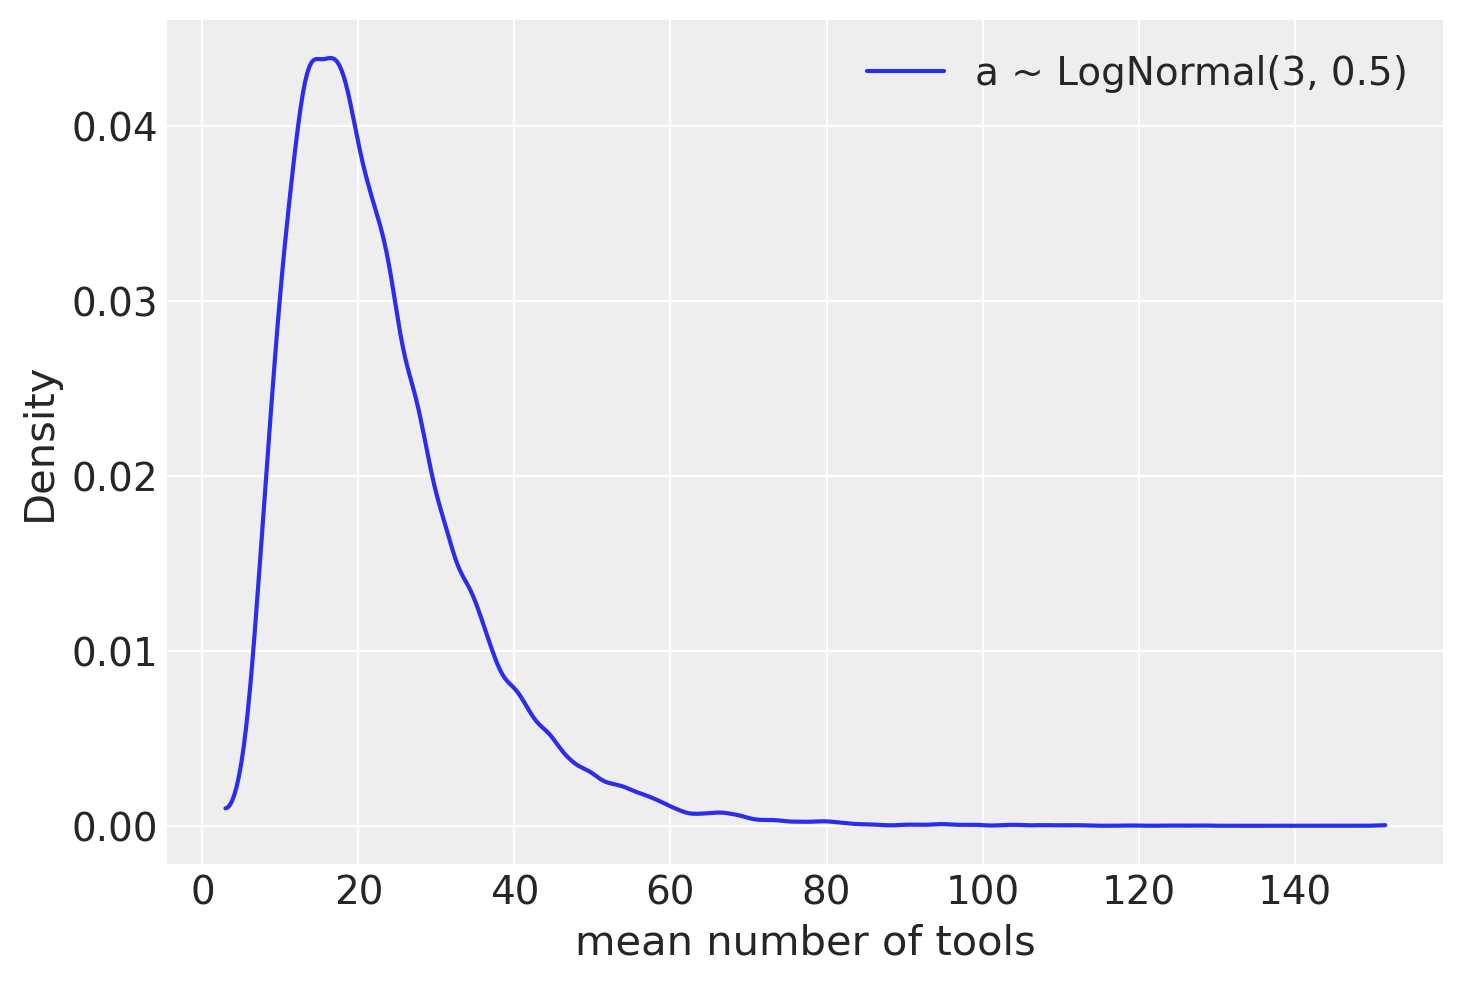

In [24]:
ax = az.plot_kde(pm.Lognormal.dist(3.0, 0.5).random(size=20_000), label="a ~ LogNormal(3, 0.5)")
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

In [25]:
def kline_prior_plot(N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None):
    """
    Utility function to plot prior predictive checks for Kline Poisson model.
    N: number of prior predictive trends.

    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tools")

    itcpts = np.random.normal(3.0, 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0.0, 10.0, N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0.0, 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError(
            "Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'."
        )

    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("log population")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("population")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("log population (std)")

    return ax

C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_12472/2817251953.py:6: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


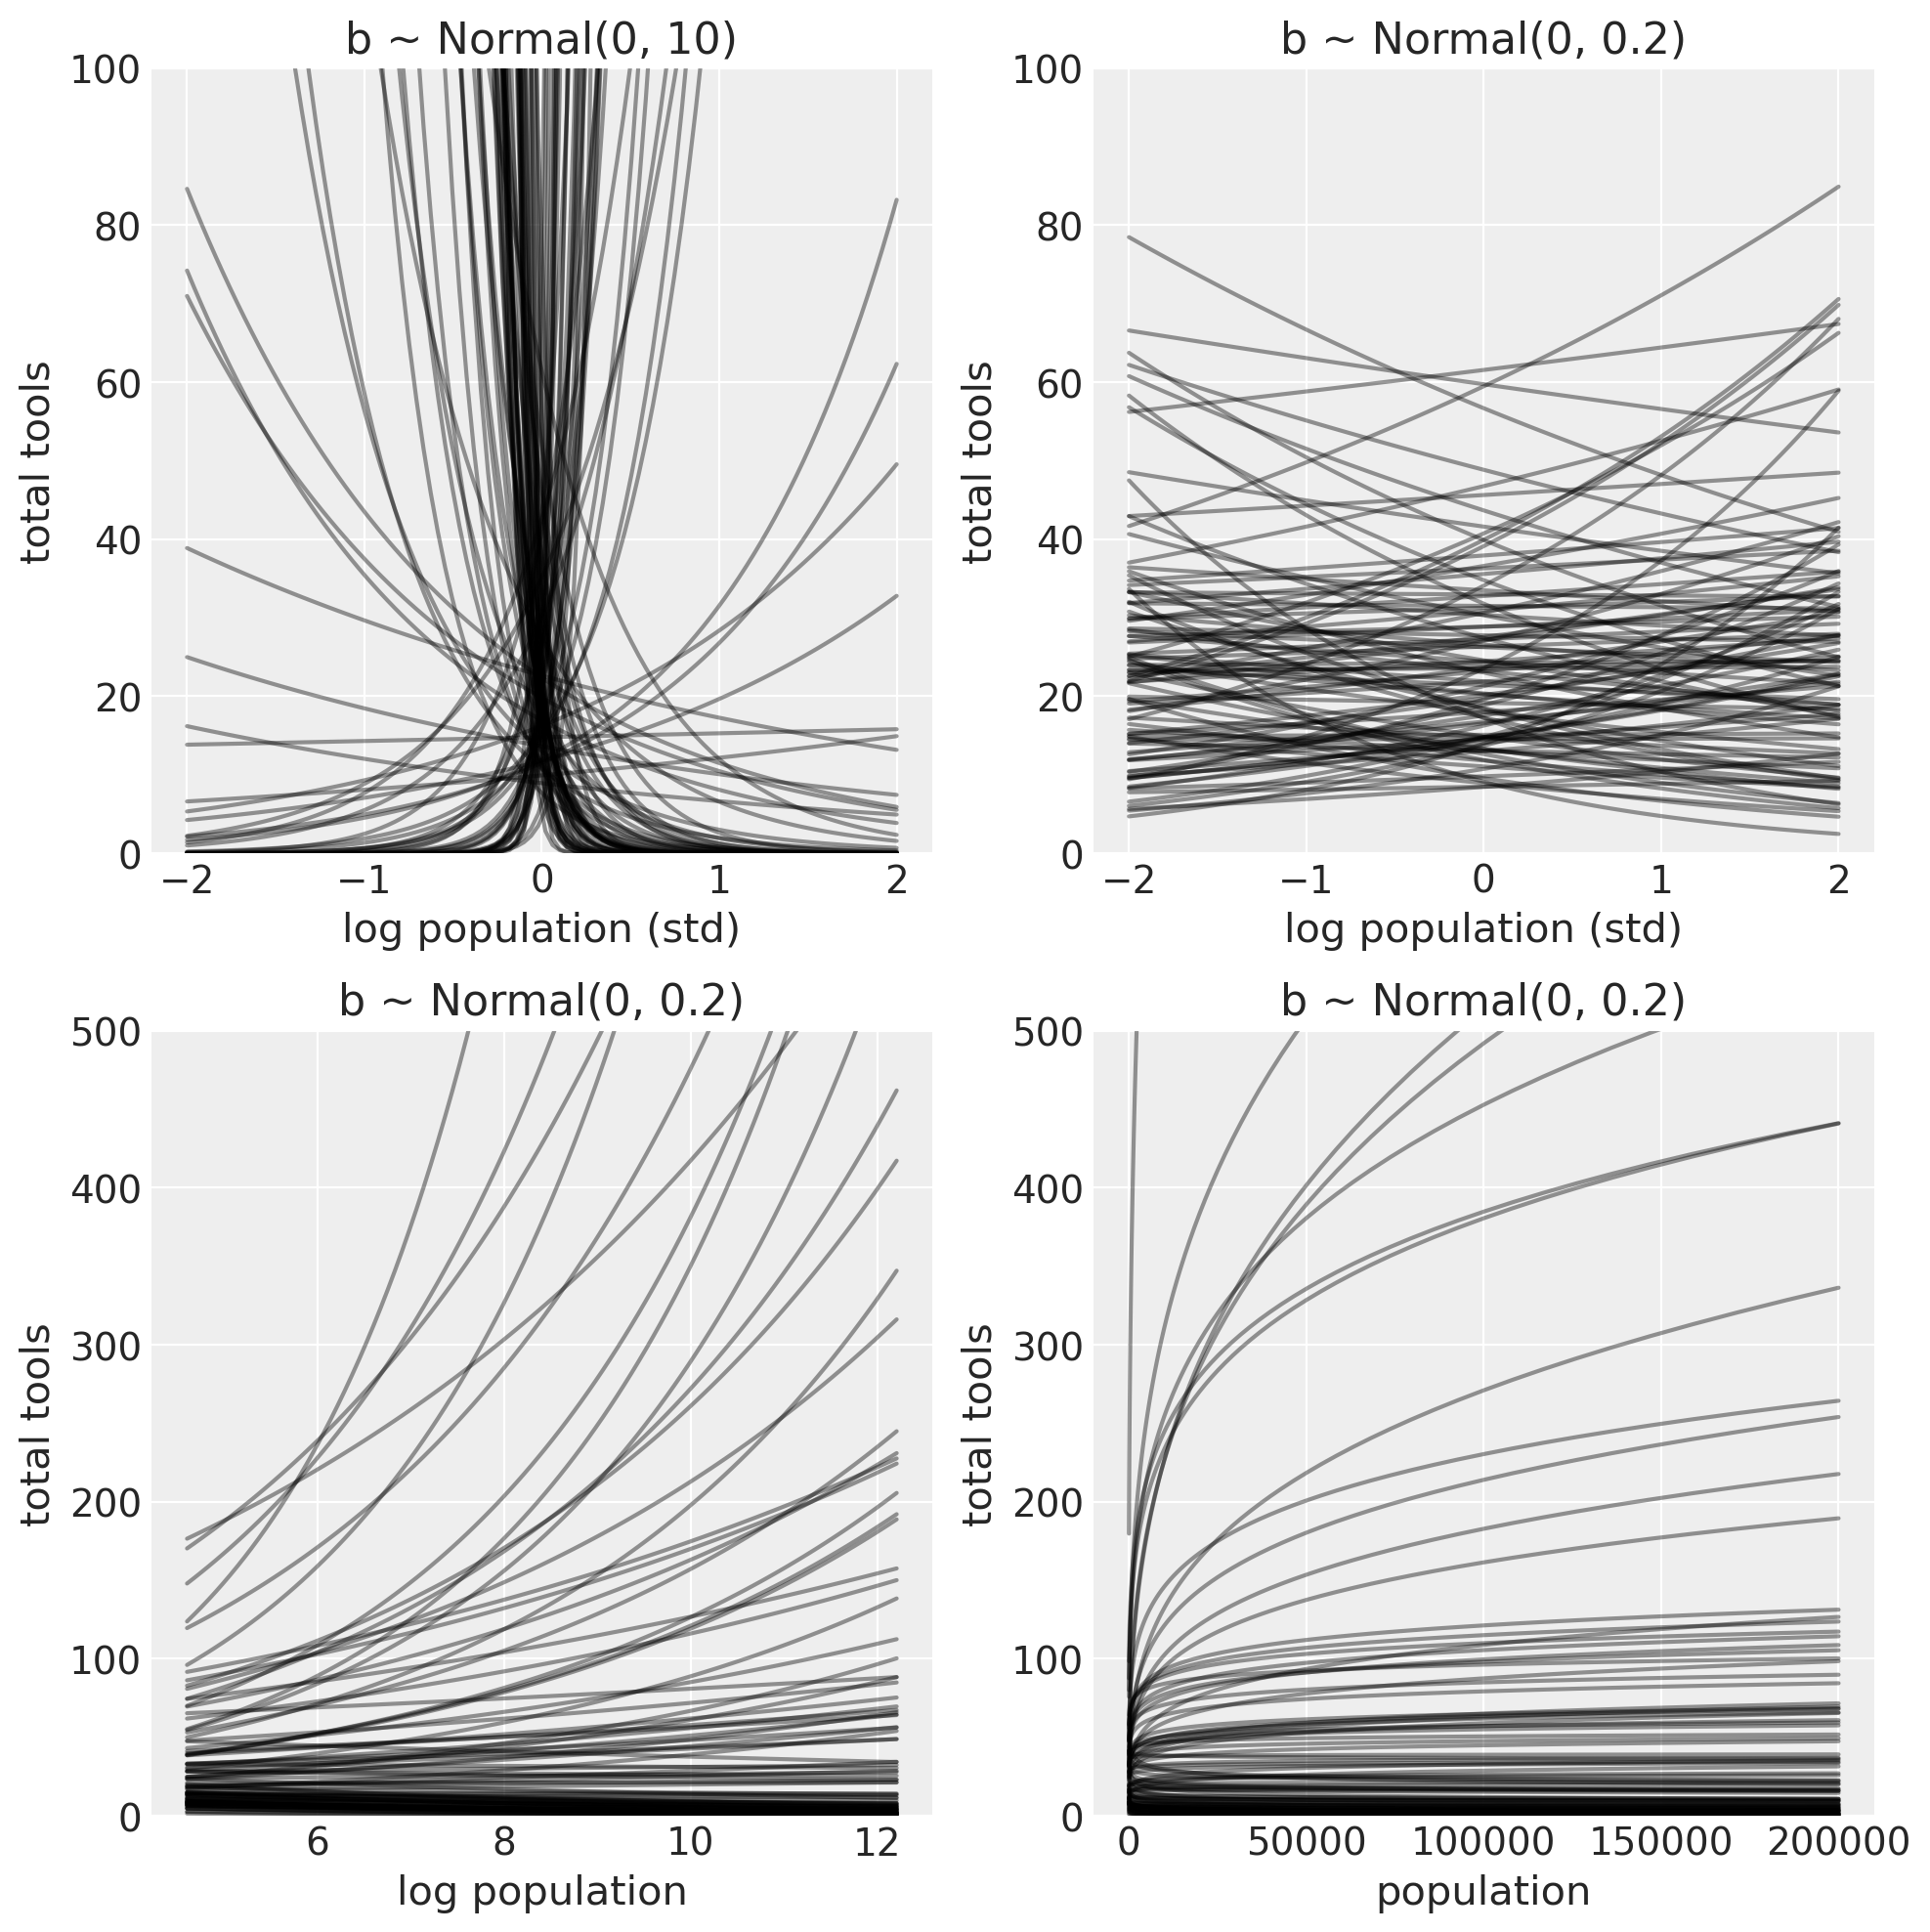

In [26]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout();

In [30]:
RANDOM_SEED=42
# intercept only
with pm.Model() as m11_9:
    a = pm.Normal("a", 3.0, 0.5)
    T = pm.Poisson("total_tools", pm.math.exp(a), observed=dk.total_tools)
    trace_11_9 = pm.sample(tune=3000, random_seed=RANDOM_SEED)

# interaction model
with pm.Model() as m11_10:
    a = pm.Normal("a", 3.0, 0.5, shape=2)
    b = pm.Normal("b", 0.0, 0.2, shape=2)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = pm.math.exp(a[cid] + b[cid] * P_)

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools)
    trace_11_10 = pm.sample(tune=3000, random_seed=42)

C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_12472/3985539359.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_9 = pm.sample(tune=3000, random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8825914248919569, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_12472/3985539359.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_10 = pm.sample(tune=3000, random_seed=42)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 29 seconds.


In [102]:
az.compare({"m11_9": trace_11_9, "m11_10": trace_11_10})

C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is

rank        loo     p_loo      d_loo    weight         se        dse  \
m11_10     0 -43.065092  7.414612   0.000000  0.950424   6.374658   0.000000   
m11_9      1 -71.011183  8.634768  27.946091  0.049576  16.098187  15.733833   

        warning loo_scale  
m11_10     True       log  
m11_9      True       log

In [103]:
# store pareto-k values for plot:
k = az.loo(trace_11_10, pointwise=True).pareto_k.values

C:\ProgramData\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [104]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns)

with m11_10:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_26352/2322359891.py:69: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


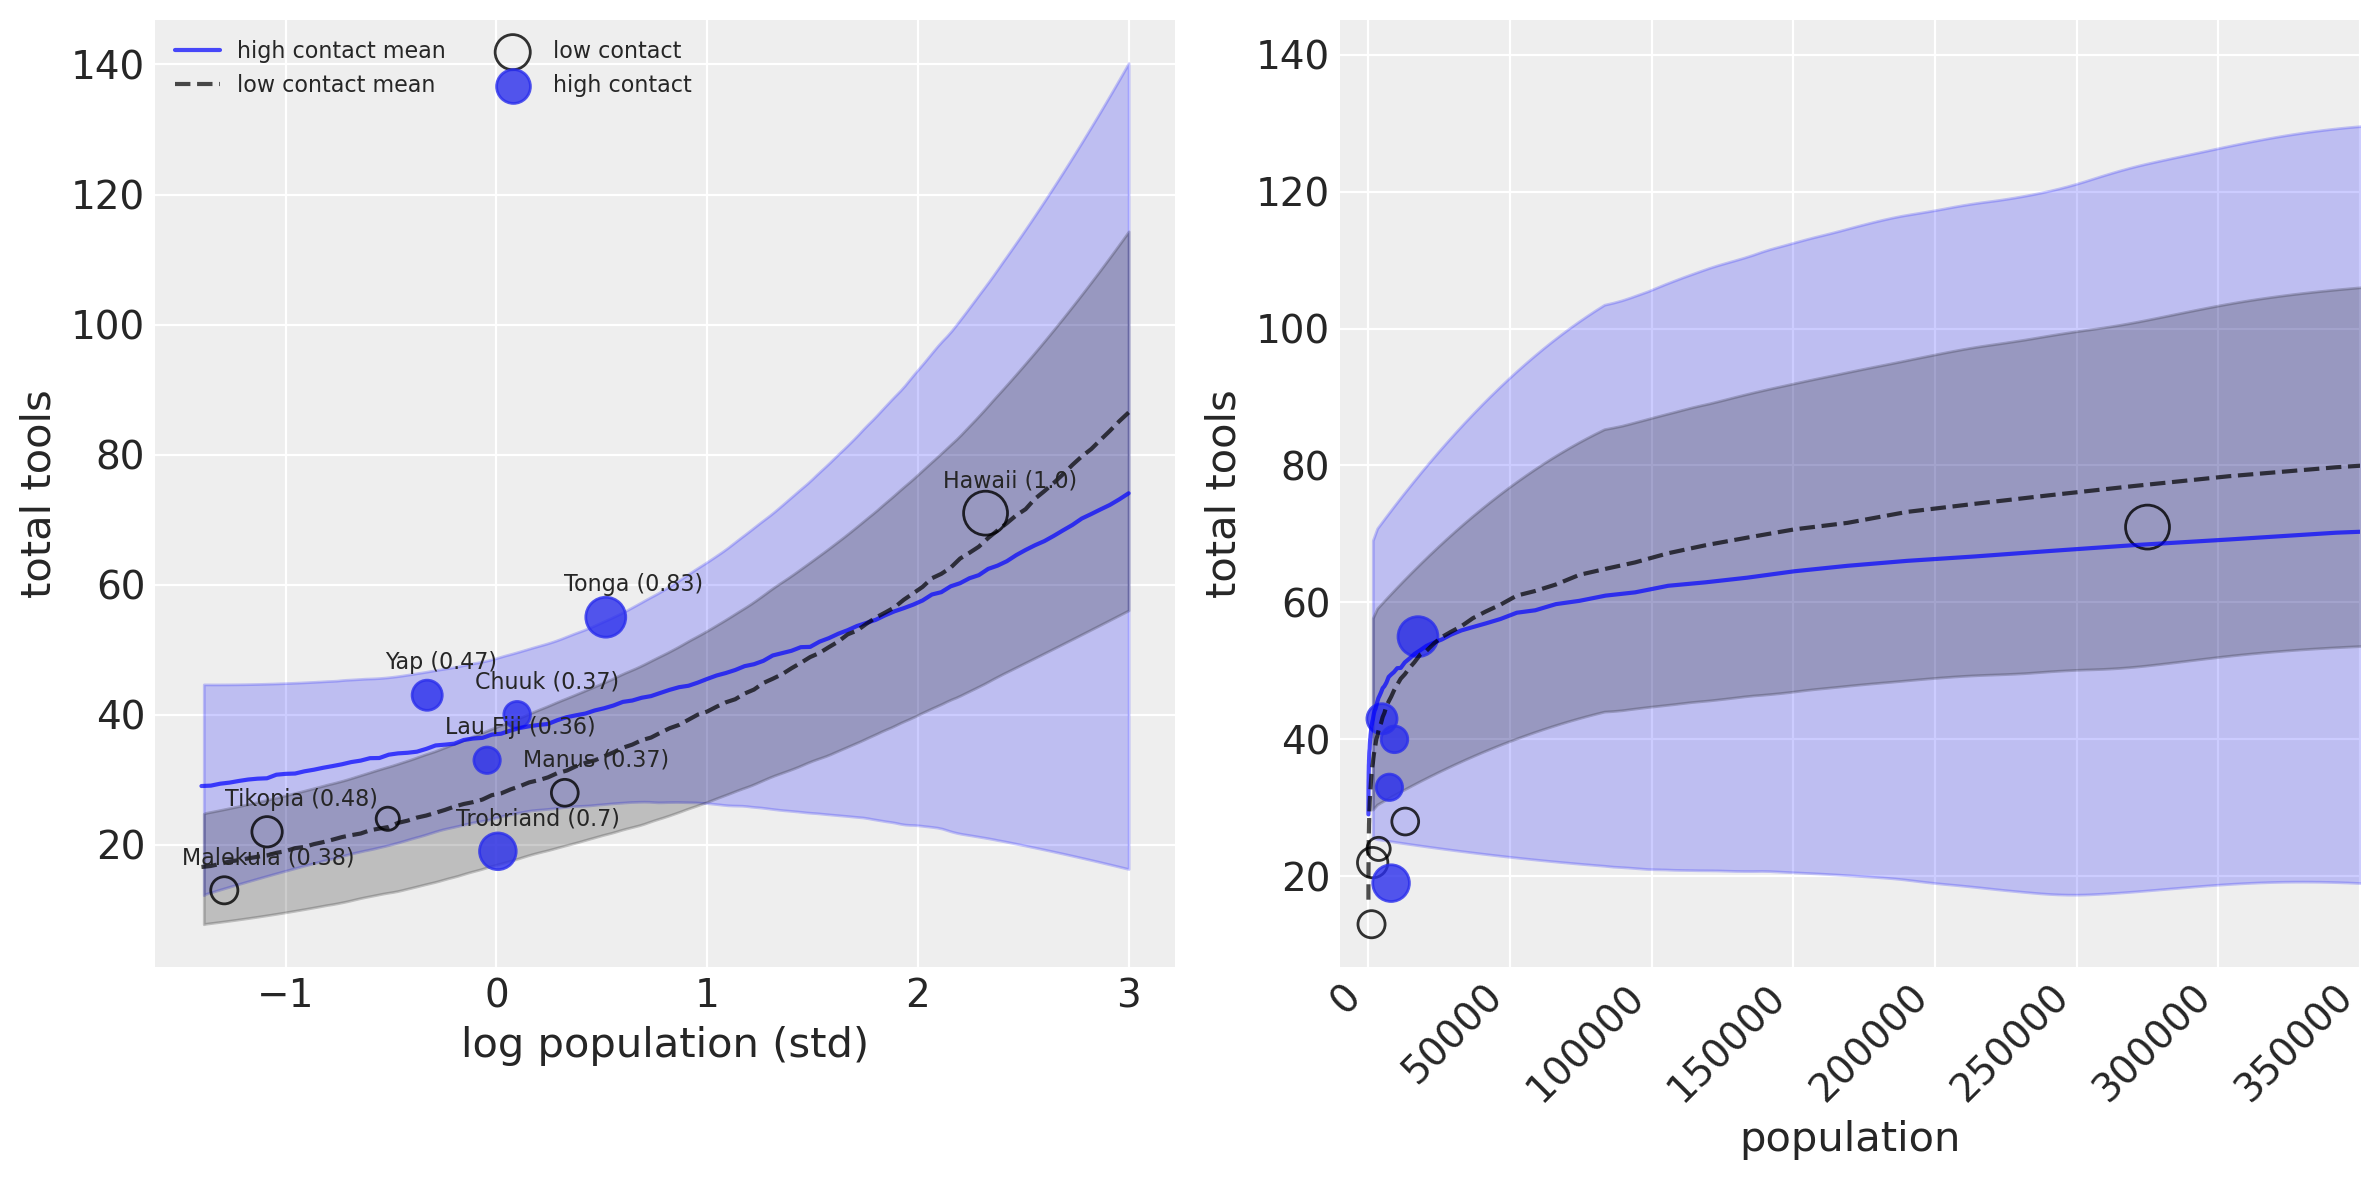

In [ ]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# scale point size to Pareto-k:
k /= k.max()
psize = 250 * k

# Plot on standardized log scale:

az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display names and k:
mask = k > 0.3
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(
        P[mask][i] - 0.2,
        dk.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(P_seq * np.log(dk.population.values).std() + np.log(dk.population.values).mean())

az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();

Using an actaul model:
    
    ∆T = αP^B − γT
where P is the population size, T is the number of tools, andα, β, and γ are parameters to be estimated.
To find an equilibrium number of tools T, just set ∆T = 0 and solve for T. This yields:
Tˆ =αP^β/γ

    

 if you give the population raw to PyMC3, the sampler will break: the scale of these data is too wide. However we can't just standardize the data, as we usually do. Why? Because some data points will then be negative, which doesn't play nice with the b exponent (try it if you don't trust me). But we'll do something similar: let's standardize the data, and then just add the absolute value of the minimum, and add yet again an epsilon -- this will ensure that our data stay positive and that the transformation will be easy to reverse when we want to plot on the natural scale:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 48 seconds.
The number of effective samples is smaller than 25% for some parameters.


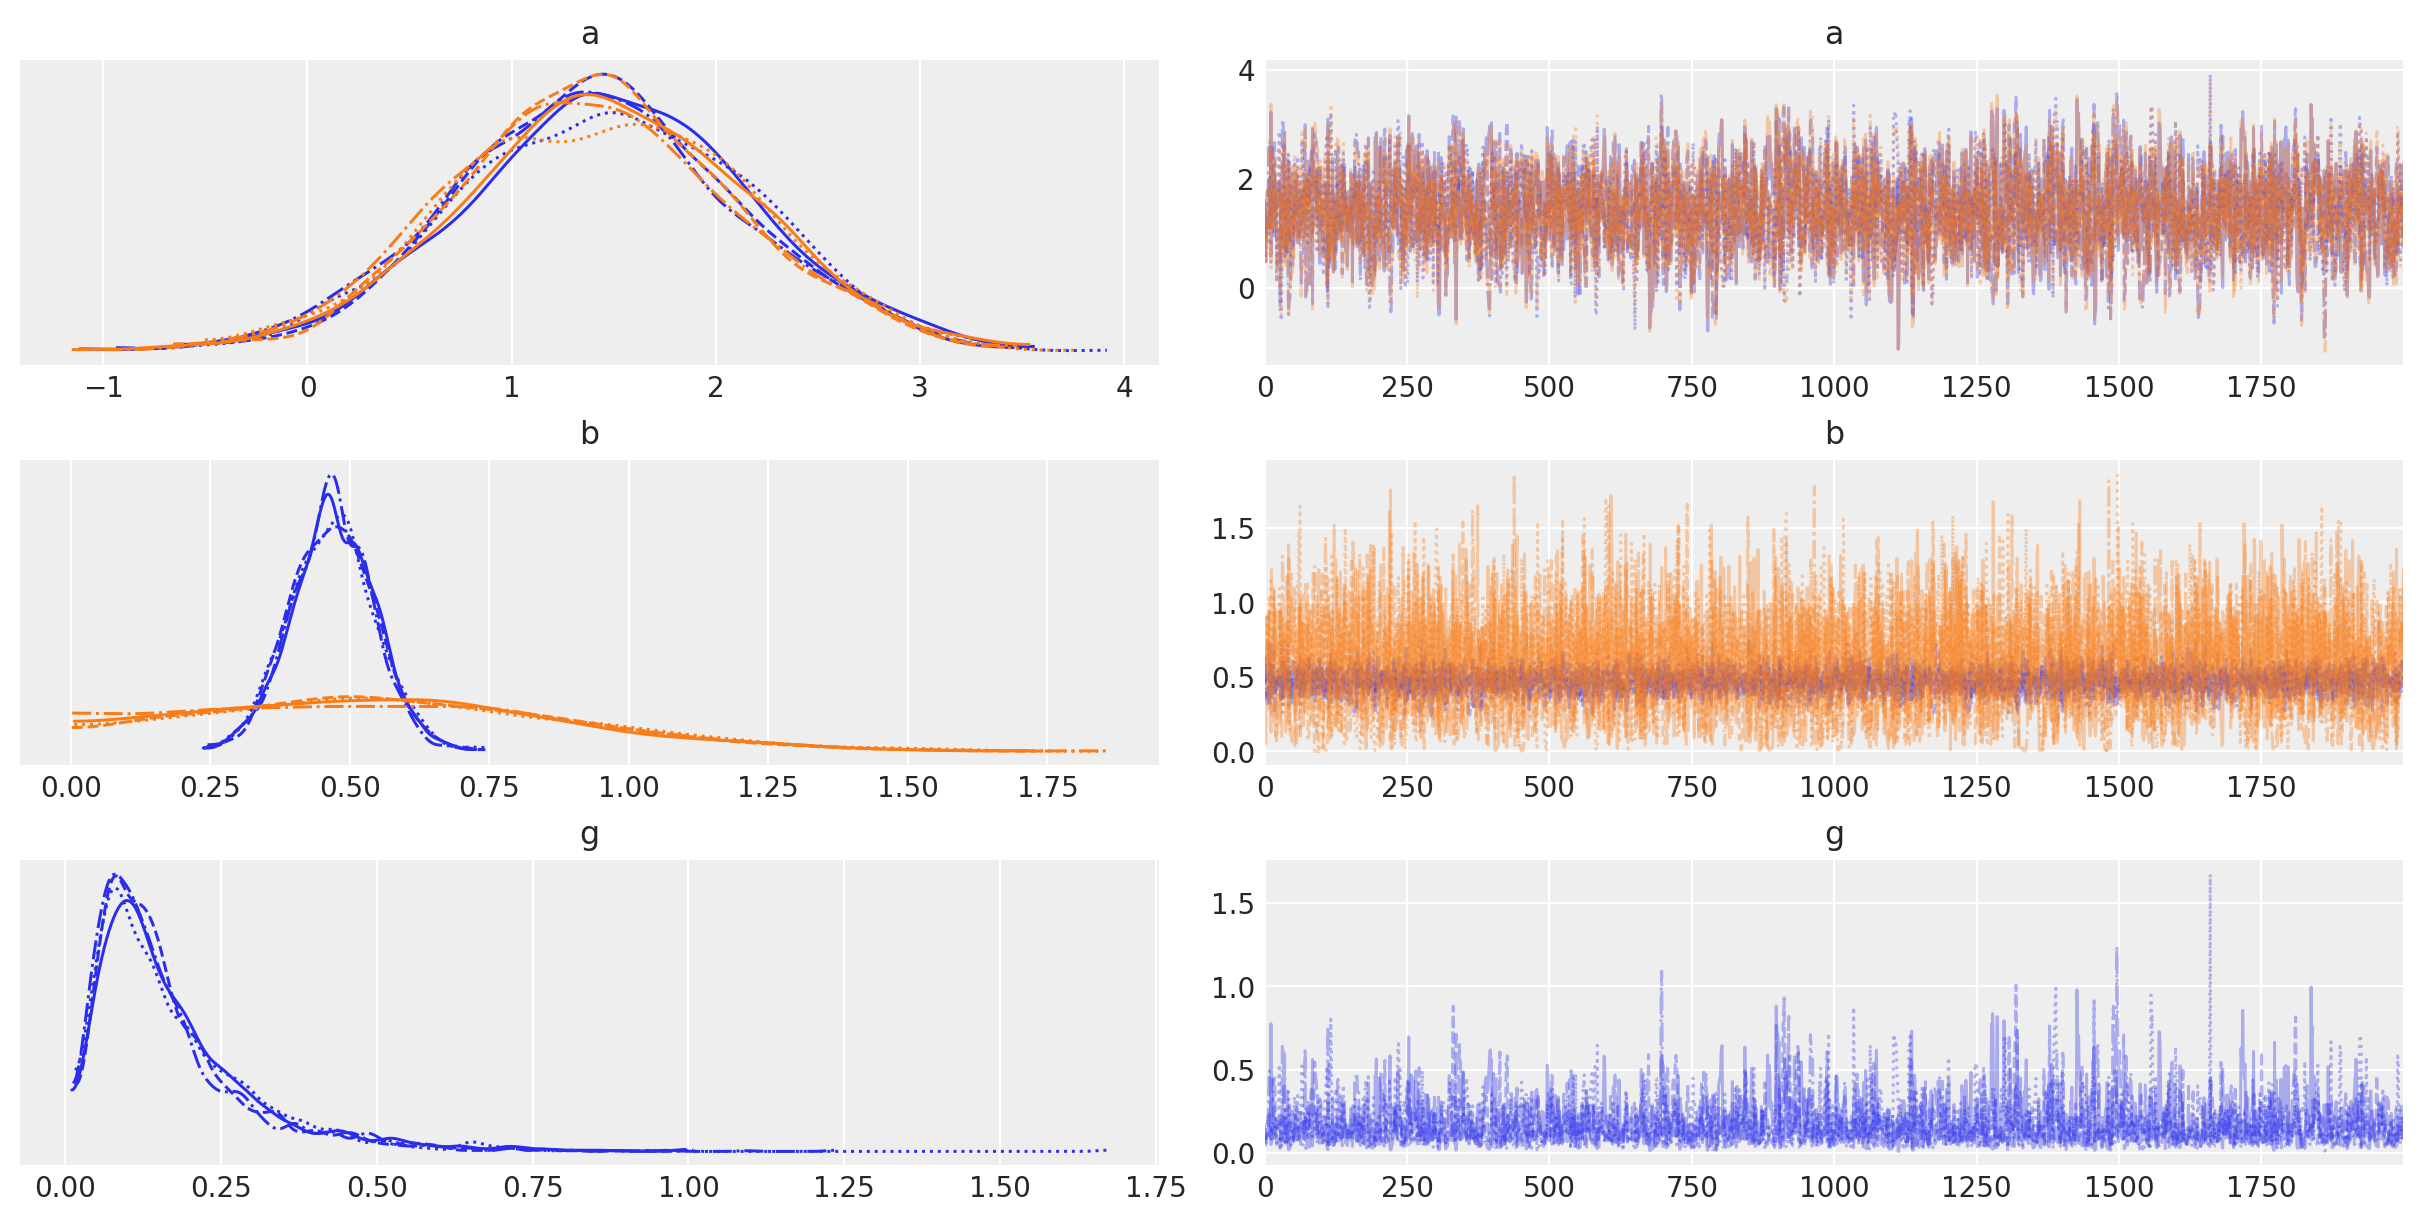

In [111]:
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0
with pm.Model() as m11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (tt.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools)
    trace_11_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)
az.plot_trace(trace_11_11, compact=True);

In [112]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])["total_tools"]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

C:\Users\gsahinpi\AppData\Local\Temp/ipykernel_26352/372660647.py:54: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


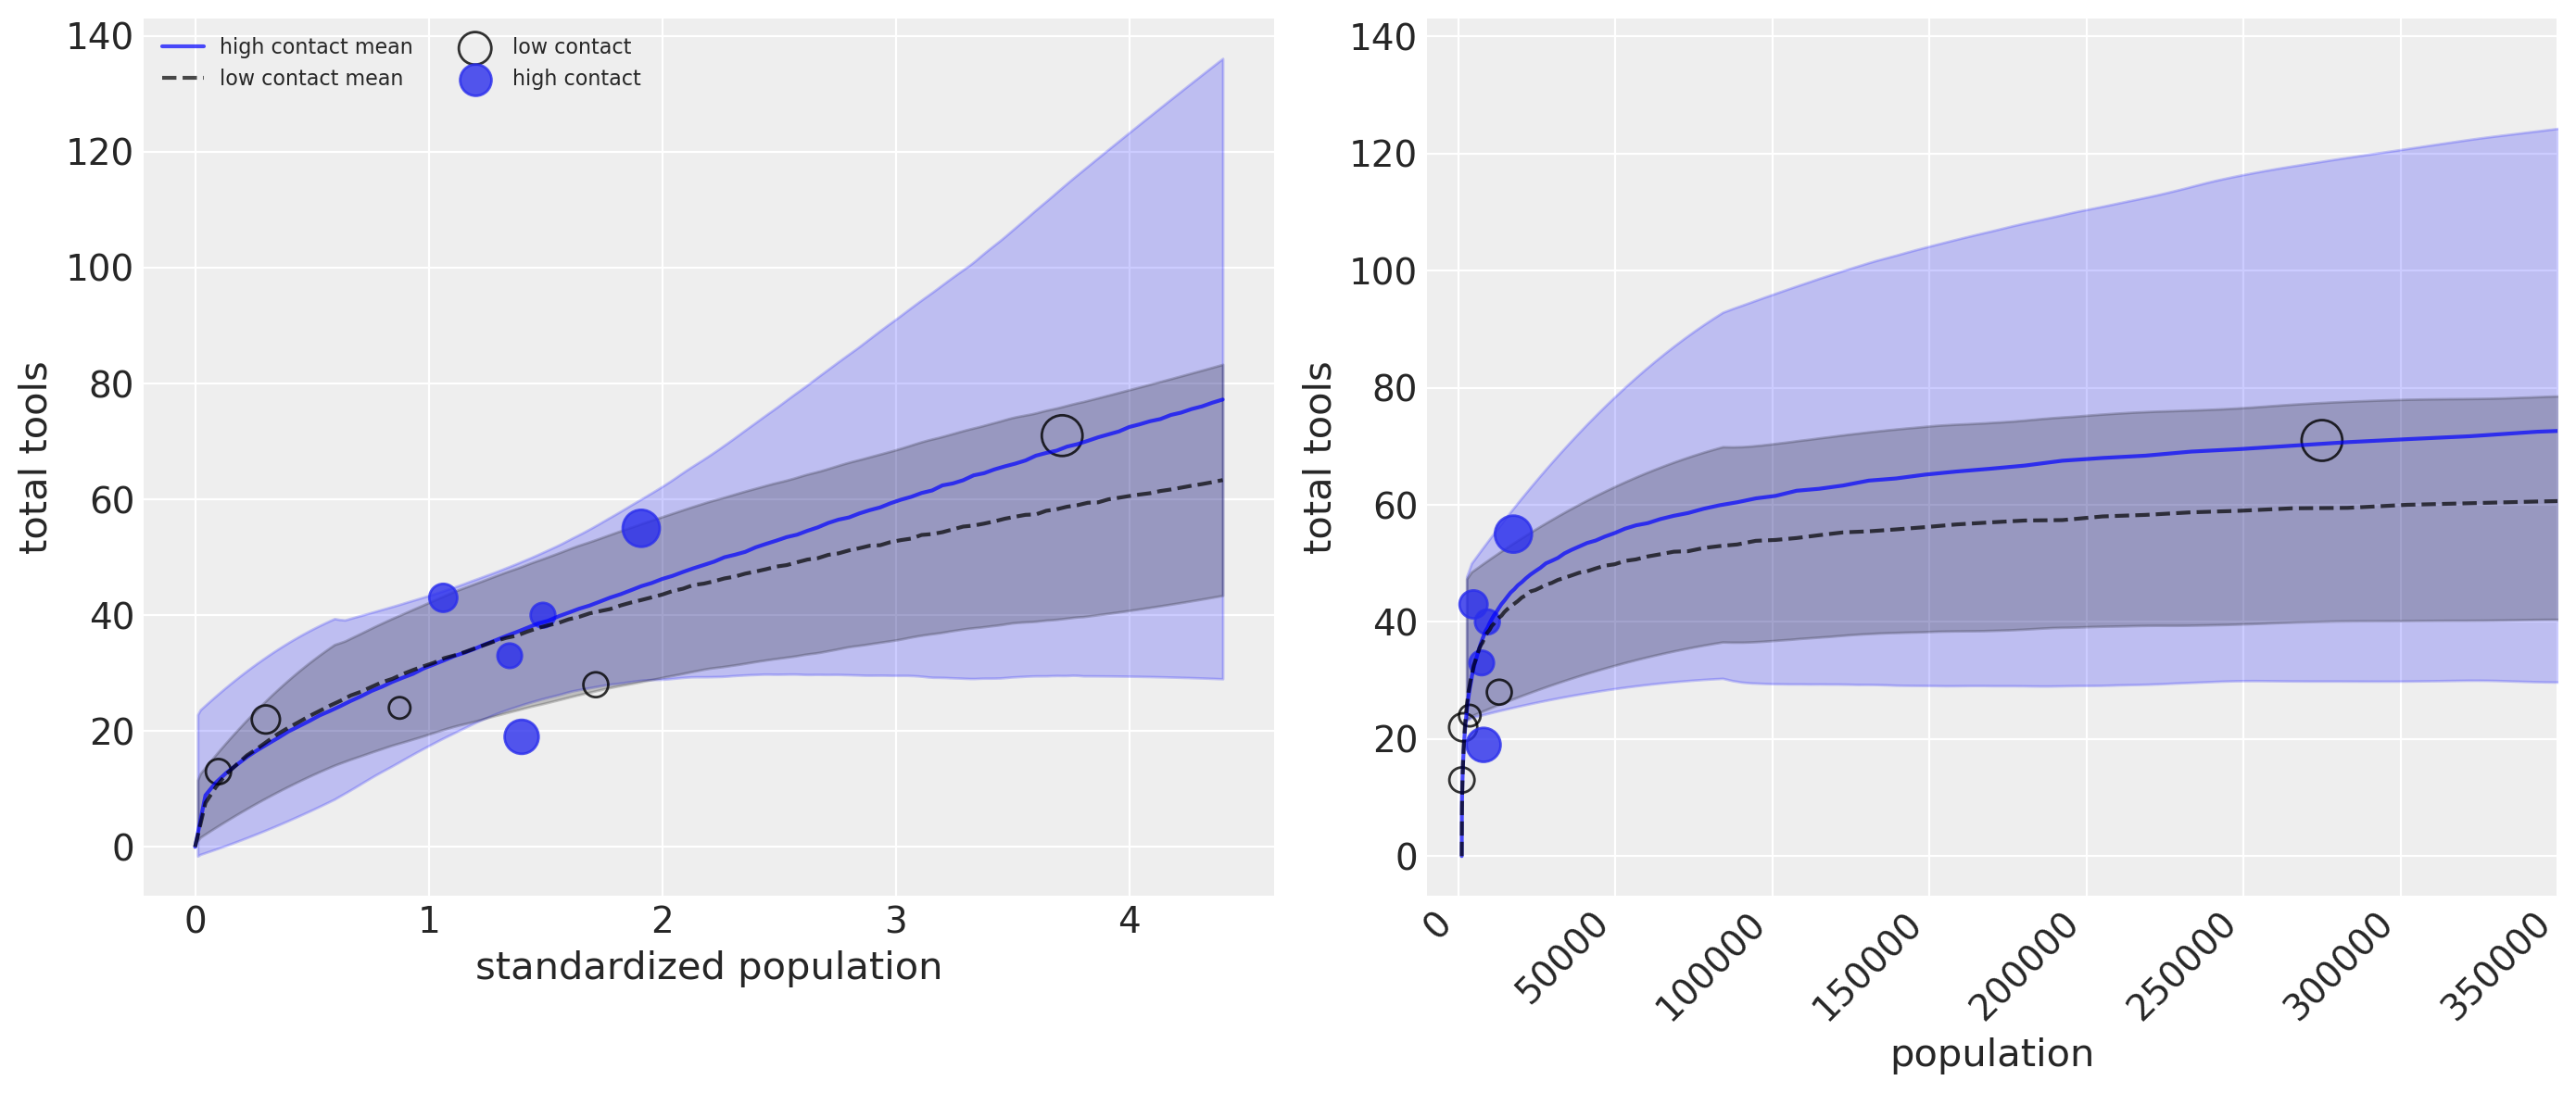

In [115]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Plot on standardized log scale:
az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel("standardized population")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize our log pop sequence:
P_seq = np.exp(
    (P_seq - 1.4) * np.log(dk.population.values).std() + np.log(dk.population.values).mean()
)

az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();